## INFO

<b>STEPS</b>

1. Hope to get excel with tab per question

2. Break each tab into .csv file (should be 5 files)

3. Generate topics for each file, sentiment analysis

4. For each topic, generate phrase frequency chart (1,3)


<b>INFO</b>
- Should result in excel with 5 tabs (original plus topic and sentiment)
- 5 summary tables to show roll up of topics (one per question)
- 10 phrase frequency charts per file (chart for each topic under each question)
- might ask for "original buckets" to be added to output table



<b>CALLOUT</b>
- if -1 topic is large
- all observations fall in less than 10 topics
- there seems to be a need for more than 10 topics

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Analytics/Metrics
from umap import UMAP
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
# Sentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

## Variables

In [2]:
# ========================= #
# Parameters for BERTopic & Sentiment
# ========================= #

TEXT_FIELD = "Text"
NUM_TOPICS = 10

# ========================= #
# Stuff for outputting data
# ========================= #
Improved_Data_Dirname = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Chevron Survey\\Improved_Data\\"

SUBJECT = 'Teaming'
#SUBJECT = 'Speak My Mind'


## Import Data

In [3]:
dirname = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Chevron Survey\\Input_Data\\"

if SUBJECT=='Teaming':
    filename = "Teaming Comments.csv"
elif SUBJECT=='Speak My Mind':
    filename = "Speak My Mind Comments.csv"

df = pd.read_csv(str(dirname)+str(filename))

In [4]:
#calculate the negative, positive, neutral and compound scores, plus verbal evaluation
def sentiment_vader(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()

    sentiment_dict = sid_obj.polarity_scores(sentence)
    negative = sentiment_dict['neg']
    neutral = sentiment_dict['neu']
    positive = sentiment_dict['pos']
    compound = sentiment_dict['compound']

    if sentiment_dict['compound'] >= 0.05 :
        overall_sentiment = "Positive"

    elif sentiment_dict['compound'] <= - 0.05 :
        overall_sentiment = "Negative"

    else :
        overall_sentiment = "Neutral"
  
    #return negative, neutral, positive, compound, overall_sentiment
    return overall_sentiment

def count_num_words(data):
    """
    Count the number of words in a string.
    """
    return len(data.split())

## NLP and Metrics

Steps:

- Topic Modeling (BERTopic)

- Analyze Sentiment for each tweet
- Count # of tweets in topic [Local]
- CountWordFrequency across topic

In [5]:
# Create UMAP model object
umap_model = UMAP(n_neighbors=5,
                  n_components=12,
                  min_dist=0.0,
                  metric='cosine',
                  random_state=100)


# Prepare embeddings
docs = df[TEXT_FIELD].tolist()
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

#vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", max_df=.80)#, min_df=2)

topic_model = BERTopic(nr_topics = NUM_TOPICS, #max number of topics
                       language = 'english',
                       umap_model=umap_model,   # using UMAP instead of vectorizer for finer grained results
                       calculate_probabilities = True,
                       min_topic_size=3,        # this is low
                       verbose=True)

topics, probabilities = topic_model.fit_transform(docs, embeddings)

Batches:   0%|          | 0/11 [00:00<?, ?it/s]

2023-06-12 10:08:13,264 - BERTopic - Reduced dimensionality
2023-06-12 10:08:13,405 - BERTopic - Clustered reduced embeddings
2023-06-12 10:08:13,766 - BERTopic - Reduced number of topics from 37 to 11


In [6]:
# Topic -1 is the catch-all bin for outliers.
# Need to modify min_df.  Believe this is the minimum number of obs to create a topic.
# From word frequency, believe ngram = 2 is good.
# ACTION: Generate more tweets and test with different min_df value.

topic_model.get_topic_info()

,Topic,Count,Name
0,-1,203,-1_to_the_and_of
1,0,34,0_chevron_to_is_in
2,1,28,1_silos_still_in_and
3,2,12,2_teaming_and_we_do
4,3,12,3_better_getting_this_space
5,4,12,4_teams_together_to_some
6,5,11,5_teams_the_are_that
7,6,11,6_yes_are_have_people
8,7,10,7_and_mcbu_mcp_hard
9,8,10,8_communication_is_has_departments


In [7]:
df_with_topics = pd.DataFrame(topic_model.get_document_info(docs))

topic_model.visualize_hierarchy()

## Add Sentiment and Word Counts

In [8]:
df_with_topics['Sentiment'] = df_with_topics['Document'].apply(sentiment_vader)
df_with_topics['Number of Words'] = df_with_topics['Document'].apply(count_num_words)

In [9]:
df_with_topics['Sentiment'].value_counts()

Positive    230
Negative     66
Neutral      56
Name: Sentiment, dtype: int64

In [10]:
df_with_topics.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document,Sentiment,Number of Words
0,There are many obstacles to be able to complet...,-1,-1_to_the_and_of,to - the - and - of - is - are - in - teams - ...,1.000000,False,Negative,27
1,Lack of collaboration was seen in during high ...,-1,-1_to_the_and_of,to - the - and - of - is - are - in - teams - ...,1.000000,False,Negative,28
2,"Not only Chevron Argentina, also opens the pos...",0,0_chevron_to_is_in,chevron - to - is - in - the - of - and - we -...,0.349678,False,Neutral,21
3,Although I feel in general teams in Chevron co...,0,0_chevron_to_is_in,chevron - to - is - in - the - of - and - we -...,0.690791,False,Positive,83
4,Silos have not been copmpletely removed. Many ...,1,1_silos_still_in_and,silos - still - in - and - to - the - factory ...,0.296712,False,Negative,34


In [12]:
df_with_topics['Number of Words'].mean()

32.74715909090909

## Output to DF

In [13]:
# Create name of file

# Just creates the string with {path} and {filename} ready to go
OUT_FILE = os.path.join(Improved_Data_Dirname, "{timestamp}_{subject}_ModelResults.csv".format(timestamp=date.today(), subject=SUBJECT))
print(OUT_FILE)

C:\Users\hlmq\OneDrive - Chevron\Desktop\Projects\Chevron Survey\Improved_Data\2023-06-12_Teaming_ModelResults.csv


In [14]:
df_with_topics.to_csv(OUT_FILE, index=False)

## Slice for Phrase Counter

TOPIC TO SLICE ON:.. -1_to_the_and_of, Observations: 203
TOPIC TO SLICE ON:.. 0_chevron_to_is_in, Observations: 34
TOPIC TO SLICE ON:.. 1_silos_still_in_and, Observations: 28
TOPIC TO SLICE ON:.. 3_better_getting_this_space, Observations: 12
TOPIC TO SLICE ON:.. 7_and_mcbu_mcp_hard, Observations: 10
TOPIC TO SLICE ON:.. 5_teams_the_are_that, Observations: 11
TOPIC TO SLICE ON:.. 6_yes_are_have_people, Observations: 11
TOPIC TO SLICE ON:.. 4_teams_together_to_some, Observations: 12
TOPIC TO SLICE ON:.. 2_teaming_and_we_do, Observations: 12
TOPIC TO SLICE ON:.. 9_wells_ad_and_roll, Observations: 9
TOPIC TO SLICE ON:.. 8_communication_is_has_departments, Observations: 10


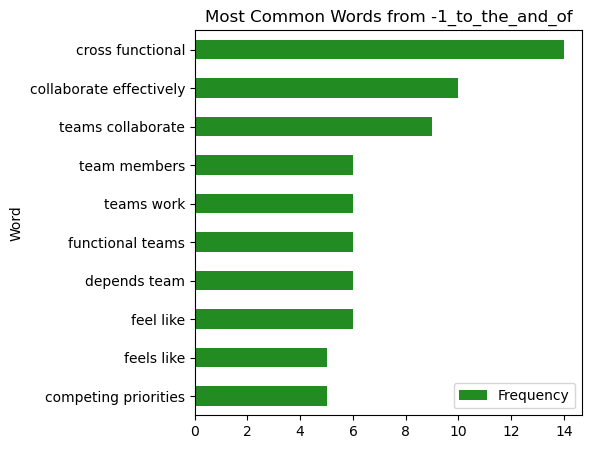

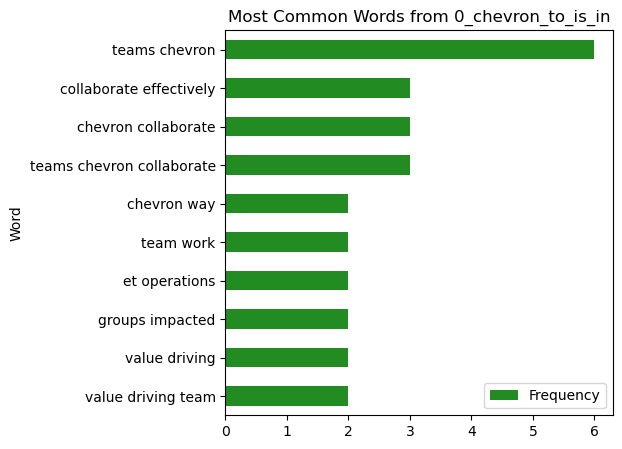

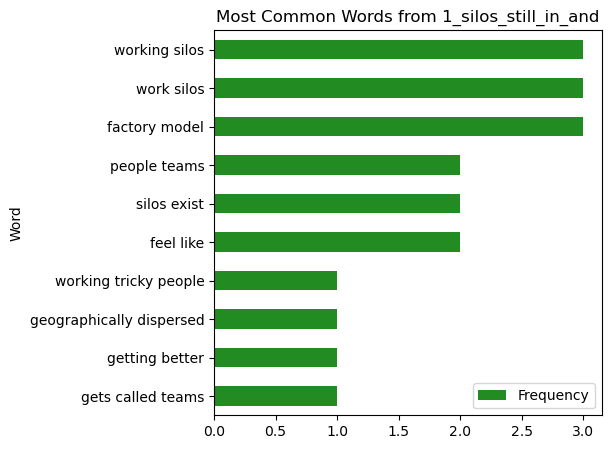

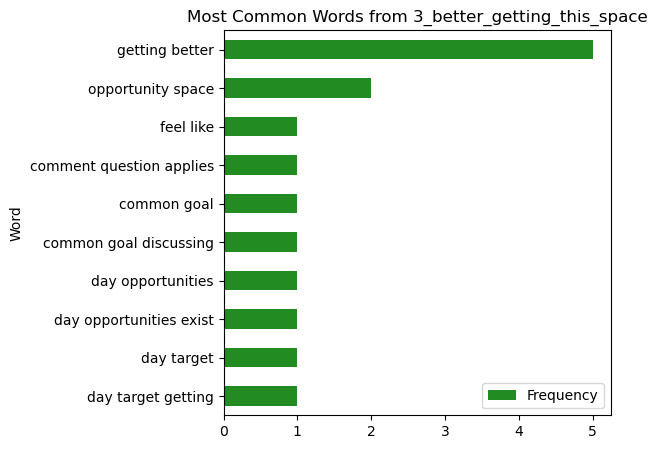

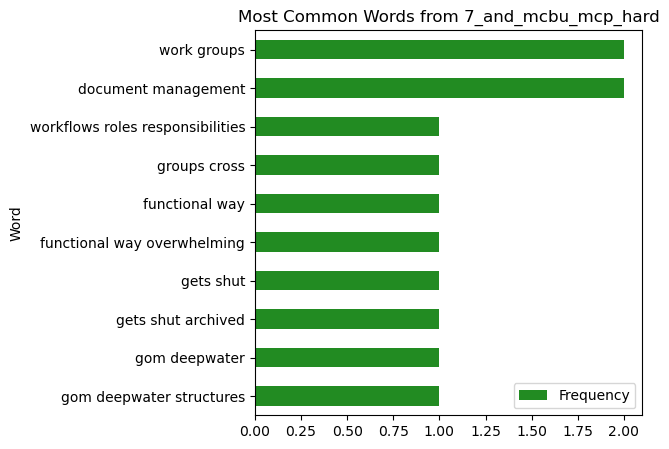

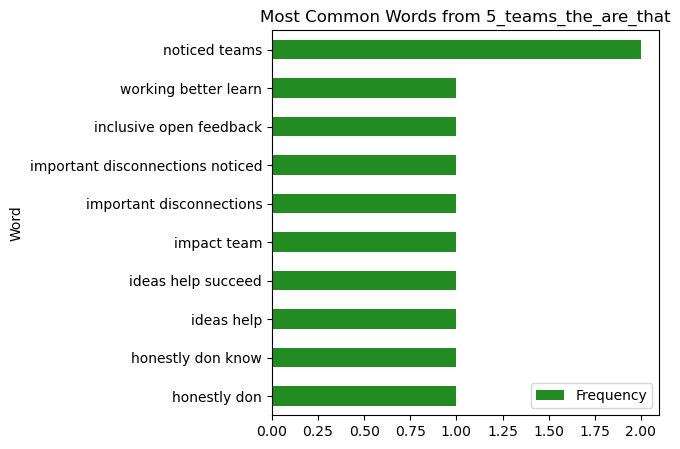

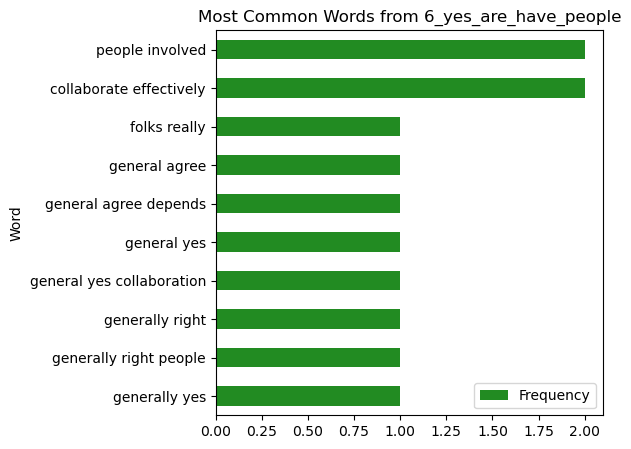

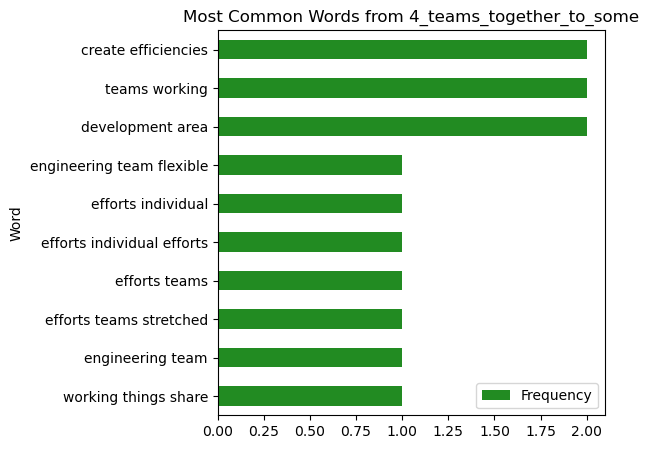

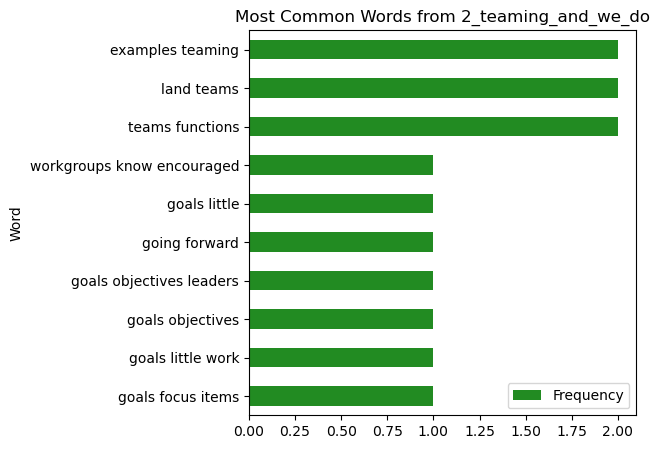

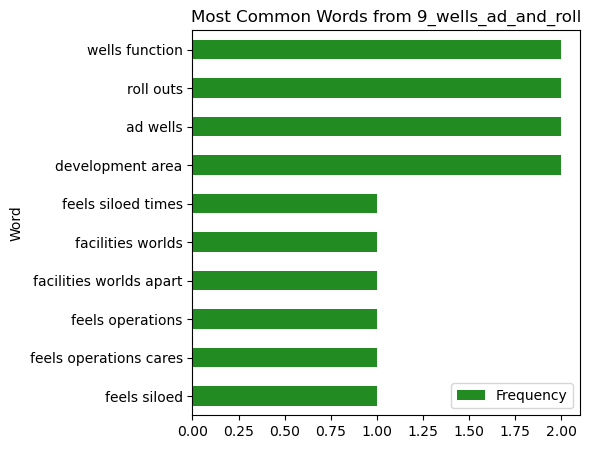

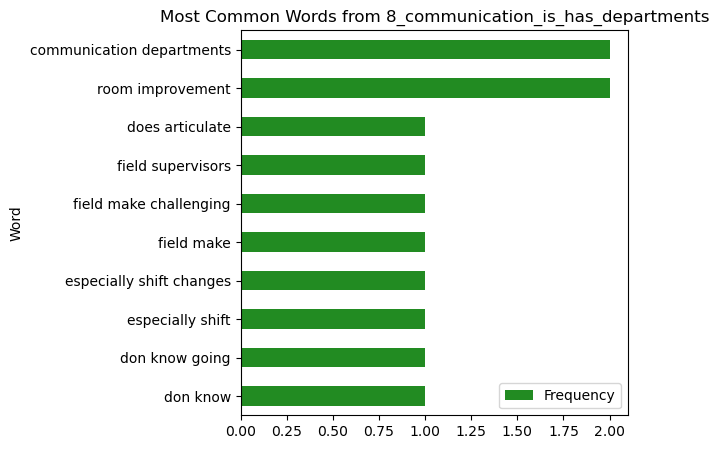

In [16]:
# Count total len of df

list_of_topics = df_with_topics['Name'].unique()

for i in list_of_topics:
    sliced_df = df_with_topics[df_with_topics["Name"]==i]
    print(f"TOPIC TO SLICE ON:.. {i}, Observations: {len(sliced_df)}")

    # CountWordFrequency

    #Create DTM
    cv = CountVectorizer(ngram_range = (2,3), stop_words='english')
    dtm = cv.fit_transform(sliced_df['Document'])
    words = np.array(cv.get_feature_names_out())

    #Look at top 10 most frequent words
    freqs=dtm.sum(axis=0).A.flatten()
    index=np.argsort(freqs)[-10:]

    # Construct dataframe
    WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index])))
    WordFreq.columns = ['Word', 'Frequency']

    # Plot horizontal bar graph
    fig, ax = plt.subplots(figsize=(5, 5))
    WordFreq.sort_values(by='Frequency').plot.barh(
                      x='Word',
                      y='Frequency',
                      ax=ax,
                      color="forestgreen")

    # COLORS: darkred, goldenrod, forestgreen, deepskyblue, rebeccapurple

    plt.title(f"Most Common Words from {i}")